In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils, psfs, opds, conf
from pynrc.nrc_utils import S, jl_poly_fit, jl_poly, frebin, pad_or_cut_to_size
from pynrc.opds import webbpsf

In [4]:
from astropy.io import fits
import six, os

In [342]:
from pynrc.nrc_utils import bp_igood
def miri_filter(filter):
    
    """
    No need to include pupil for the 
    """
    
    filter = filter.upper()
    filt_dir = webbpsf.utils.get_webbpsf_data_path() + 'MIRI/filters/'
    fname = f'{filter}_throughput.fits'

    bp_name = filter

    hdulist = fits.open(filt_dir + fname)
    wtemp = hdulist[1].data['WAVELENGTH']
    ttemp = hdulist[1].data['THROUGHPUT']

    fscale_dict = {
        'F560W' : 0.30, 'F770W' : 0.35, 'F1000W': 0.35,
        'F1130W': 0.30, 'F1280W': 0.30, 'F1500W': 0.35,
        'F1800W': 0.30, 'F2100W': 0.25, 'F2550W': 0.20,

        'F1065C': 0.3, 'F1140C': 0.3, 'F1550C': 0.3, 'F2300C': 0.25,
        'FND': 0.0008
    }

    ttemp = fscale_dict[filter] * ttemp / ttemp.max()
    
    bp = S.ArrayBandpass(wtemp, ttemp, name=bp_name)

    # Select which wavelengths to keep
    igood = bp_igood(bp, min_trans=0.005, fext=0.1)
    wgood = (bp.wave)[igood]
    w1 = wgood.min()
    w2 = wgood.max()
    wrange = w2 - w1

    # Resample to common dw to ensure consistency
    dw_arr = bp.wave[1:] - bp.wave[:-1]
    dw = np.median(dw_arr)
    warr = np.arange(w1,w2, dw)
    bp = bp.resample(warr)

    # Need to place zeros at either end so Pysynphot doesn't extrapolate
    warr = np.concatenate(([bp.wave.min()-dw],bp.wave,[bp.wave.max()+dw]))
    tarr = np.concatenate(([0],bp.throughput,[0]))
    bp   = S.ArrayBandpass(warr, tarr, name=bp_name)
        
    return bp


In [499]:
from webbpsf import MIRI as webbpsf_MIRI
class MIRI_psf_coeffs(webbpsf_MIRI):
    
    def __init__(self, filter=None, pupil_mask=None, image_mask=None, 
                 fov_pix=None, oversample=None):
        
        webbpsf_MIRI.__init__(self)
        
        if filter is not None:
            self.filter = filter
        if pupil_mask is not None:
            self.pupil_mask = pupil_mask
        if image_mask is not None:
            self.image_mask = image_mask
            
        # Don't include SI WFE error for coronagraphy
        self.include_si_wfe = False if self.is_coron else True
        
        # Default setting for FOV pixels
        self._fov_pix = 33 if fov_pix is None else fov_pix
        self._oversample = oversample
        
        # Setting these to one choose default values at runtime
        self._npsf = None
        self._ndeg = None
        
        # Legendre polynomials are more stable
        self.use_legendre = True
        
        # Turning on quick perform fits over filter bandpasses independently
        # The smaller wavelength range requires fewer monochromaic wavelengths
        # and lower order polynomial fits
        self._quick = True
        
        self._opd_default = ('OPD_RevW_ote_for_MIRI_predicted.fits.gz', 0)
        self.pupilopd = self._opd_default
        self._pupilopd_copy = None
        self.wfe_drift = 0
        
        # Name to save array of oversampled coefficients
        self._save_dir = None
        self._save_name = None
        
        # No jitter for coronagraphy
        self.options['jitter'] = None if self.is_coron else 'gaussian'
        self.options['jitter_sigma'] = 0.003

    @property
    def save_dir(self):
        """Coefficient save directory"""
        # Default name
        if self._save_dir is None:
            # Name to save array of oversampled coefficients
            save_dir = conf.PYNRC_PATH + 'psf_coeffs/'
            ## Create directory if it doesn't already exist
            #if not os.path.isdir(self._save_dir):
            #    os.makedirs(self._save_dir)
    @save_dir.setter
    def save_dir(self, value):
        self._save_dir = value
        
    @property
    def save_name(self):
        """Coefficient file name"""
        save_name = self._save_name
        save_name = self.gen_save_name() if save_name is None else save_name
        return save_name
    @save_name.setter
    def save_name(self, value):
        self._save_name = value
        
    @property
    def bandpass(self):
        return miri_filter(self.filter)
        
    @property
    def is_coron(self):
        """
        Corongraphic observations based on pupil mask settings
        """
        pupil = self.pupil_mask
        return (pupil is not None) and (('LYOT' in pupil) or ('FQPM' in pupil))
    @property
    def is_slitspec(self):
        """
        LRS observations based on pupil mask settings
        """
        pupil = self.pupil_mask
        return (pupil is not None) and ('LRS' in pupil)
    
    @property
    def fov_pix(self):
        fov_pix = 33 if self._fov_pix is None else self._fov_pix
        return fov_pix
    @fov_pix.setter
    def fov_pix(self, value):
        self._fov_pix = value
        
    @property
    def oversample(self):
        if self._oversample is None:
            oversample = 2 if self.is_coron else 4
        else:
            oversample = self._oversample
        return oversample
    @oversample.setter
    def oversample(self, value):
        self._oversample = value
    
    @property
    def npsf(self):
        
        npsf = self._npsf
        
        # Default to 10 PSF simulations per um
        w1 = self.bandpass.wave.min() / 1e4
        w2 = self.bandpass.wave.max() / 1e4
        if npsf is None:
            dn = 10 
            npsf = int(np.ceil(dn * (w2-w1)))

        # Want at least 5 monochromatic PSFs
        npsf = 5 if npsf<5 else int(npsf)

        # Number of points must be greater than degree of fit
        npsf = self.ndeg+1 if npsf<=self.ndeg else int(npsf)

        return npsf
    
    @npsf.setter
    def npsf(self, value):
        self._npsf = value
        
    @property
    def ndeg(self):
        ndeg = self._ndeg
        if ndeg is None:
            # TODO: Quantify these better
            if self.use_legendre:
                ndeg = 4 if self._quick else 7
            else:
                ndeg = 4 if self._quick else 7
        return ndeg
    @ndeg.setter
    def ndeg(self, value):
        self._ndeg = value

    @webbpsf_MIRI.detector_position.setter
    def detector_position(self, position):
        try:
            x, y = map(int, position)
        except ValueError:
            raise ValueError("Detector pixel coordinates must be a pair of numbers, not {}".format(position))
        self._detector_position = (int(position[0]), int(position[1]))
    
    def mask_image(self, npix=None, pixelscale=None, detector_orientation=True):
        """
        Return an image representation of the focal plane mask.
        For 4QPM, we should the phase offsets (0 or 1), whereas
        the Lyot and LRS slit masks return transmission.
        
        Parameters
        ==========
        npix : int
            Number of pixels in output image. If not set, then
            is automatically determined based on mask FoV and
            `pixelscale`
        pixelscale : float
            Size of output pixels in units of arcsec. If not specified,
            then selects nominal detector pixel scale.
        detector_orientation : bool
            Should the output image be rotated to be in detector coordinates?
            If set to False, then output mask is rotated along V2/V3 axes.
        """
        
        def make_fqpm_wrapper(name, wavelength):
            opticslist = [poppy.IdealFQPM(wavelength=wavelength, name=self.image_mask, rotation=rot1, **offsets),
                          poppy.SquareFieldStop(size=24, rotation=rot2, **offsets)]
            container = poppy.CompoundAnalyticOptic(name=name, opticslist=opticslist)
            return container
        
        rot1 = -self._rotation if detector_orientation else 0
        rot2 = 0 if detector_orientation else self._rotation
        offsets = {'shift_x': self.options.get('coron_offset_x', None),
                   'shift_y': self.options.get('coron_offset_y', None)}
        
        
        pixelscale = self.pixelscale if pixelscale is None else pixelscale

        if self.image_mask == 'FQPM1065':
            full_pad = 2*np.max(np.abs(xy_rot(12, 12, rot2)))
            npix = int(full_pad / pixelscale + 0.5) if npix is None else npix
            wave = poppy.Wavefront(wavelength=10.65e-6, npix=npix, pixelscale=pixelscale)
            mask = make_fqpm_wrapper("MIRI FQPM 1065", 10.65e-6)
            im = np.real(mask.get_phasor(wave))
            im /= im.max()
        elif self.image_mask == 'FQPM1140':
            full_pad = 2*np.max(np.abs(xy_rot(12, 12, rot2)))
            npix = int(full_pad / pixelscale + 0.5) if npix is None else npix
            wave = poppy.Wavefront(wavelength=11.4e-6, npix=npix, pixelscale=pixelscale)
            mask = make_fqpm_wrapper("MIRI FQPM 1140", 11.40e-6)
            im = np.real(mask.get_phasor(wave))
            im /= im.max()
        elif self.image_mask == 'FQPM1550':
            full_pad = 2*np.max(np.abs(xy_rot(12, 12, rot2)))
            npix = int(full_pad / pixelscale + 0.5) if npix is None else npix
            wave = poppy.Wavefront(wavelength=15.5e-6, npix=npix, pixelscale=pixelscale)
            mask = make_fqpm_wrapper("MIRI FQPM 1550", 15.50e-6)
            im = np.real(mask.get_phasor(wave))
            im /= im.max()
        elif self.image_mask == 'LYOT2300':
            full_pad = 2*np.max(np.abs(xy_rot(15, 15, rot2)))
            npix = int(full_pad / pixelscale + 0.5) if npix is None else npix
            wave = poppy.Wavefront(wavelength=23e-6, npix=npix, pixelscale=pixelscale)
            opticslist = [poppy.CircularOcculter(radius=4.25 / 2, name=self.image_mask, rotation=rot1, **offsets),
                          poppy.BarOcculter(width=0.722, height=31, rotation=rot1, **offsets),
                          poppy.SquareFieldStop(size=30, rotation=rot2, **offsets)]
            mask = poppy.CompoundAnalyticOptic(name="MIRI Lyot Occulter", opticslist=opticslist)
            im = mask.get_transmission(wave)
        elif self.image_mask == 'LRS slit':
            full_pad = 2*np.max(np.abs(xy_rot(2.5, 2.5, rot2)))
            npix = int(full_pad / pixelscale + 0.5) if npix is None else npix
            wave = poppy.Wavefront(wavelength=23e-6, npix=npix, pixelscale=pixelscale)
            mask = poppy.RectangularFieldStop(width=4.7, height=0.51, rotation=rot2, 
                                              name=self.image_mask, **offsets)
            im = mask.get_transmission(wave)
        else:
            im = np.ones([npix,npix])
        
        return im
        
    def get_opd_info(self, opd=None, HDUL_to_OTELM=True):
        """
        Parse out OPD information for a given OPD, which 
        can be a file name, tuple (file,slice), HDUList,
        or OTE Linear Model. Returns dictionary of some
        relevant information for logging purposes.
        The dictionary has an OPD version as an OTE LM.
        
        This outputs an OTE Linear Model. 
        In order to update instrument class:
            >>> opd_dict = inst.get_opd_info()
            >>> opd_new = opd_dict['pupilopd']
            >>> inst.pupilopd = opd_new
            >>> inst.pupil = opd_new
        """
        
        # Pupil OPD file name
        if opd is None:
            opd = self.pupilopd
            
        # If OPD is None or a string, make into tuple
        if opd is None:  # Default OPD
            opd = self._opd_default
        elif isinstance(opd, six.string_types):
            opd = (opd, 0)
            
        # Parse OPD info
        if isinstance(opd, tuple):
            if not len(opd)==2:
                raise ValueError("opd passed as tuple must have length of 2.")
            # Filename info
            opd_name = opd[0] # OPD file name
            opd_num  = opd[1] # OPD slice
            rev = [s for s in opd_name.split('_') if "Rev" in s]
            rev = '' if len(rev)==0 else rev[0]
            opd_str = '{}slice{:.0f}'.format(rev,opd_num)
            opd = OPDFile_to_HDUList(opd_name, opd_num)
        elif isinstance(opd, fits.HDUList):
            # A custom OPD is passed. 
            opd_name = 'OPD from FITS HDUlist'
            opd_num = 0
            opd_str = 'OPDcustomFITS'
        elif isinstance(opd, poppy.OpticalElement):
            # OTE Linear Model
            opd_name = 'OPD from OTE LM'
            opd_num = 0
            opd_str = 'OPDcustomLM'
        else:
            raise ValueError("OPD must be a string, tuple, HDUList, or OTE LM.")
            
        # OPD should now be an HDUList or OTE LM
        # Convert to OTE LM if HDUList
        if HDUL_to_OTELM and isinstance(opd, fits.HDUList):
            hdul = opd

            header = hdul[0].header
            header['ORIGINAL'] = (opd_name,   "Original OPD source")
            header['SLICE']    = (opd_num,    "Slice index of original OPD")
            header['WFEDRIFT'] = (self.wfe_drift, "WFE drift amount [nm]")

            name = 'Modified from ' + opd_name
            opd = OTE_Linear_Model_WSS(name=name, opd=hdul, opd_index=opd_num, transmission=self.pupil)
            
        out_dict = {'opd_name':opd_name, 'opd_num':opd_num, 'opd_str':opd_str, 'pupilopd':opd}
        return out_dict
    
    def drift_opd(self, opd=None):
        """
        A quick method to drift the pupil OPD. This function applies 
        some WFE drift to input OPD file by breaking up the wfe_drift 
        attribute into thermal, frill, and IEC components. If we want 
        more realistic time evolution, then we should use the procedure 
        in dev_utils/WebbPSF_OTE_LM.ipynb to create a time series of OPD
        maps, which can then be passed directly to create unique PSFs.
        
        This outputs an OTE Linear Model. 
        In order to update instrument class:
            >>> opd_new = inst.drift_opd()
            >>> inst.pupilopd = opd_new
            >>> inst.pupil = opd_new
        """
        wfe_drift = self.wfe_drift
        
        # Get Pupil OPD info and convert to OTE LM
        opd_dict = self.get_opd_info(opd)
        opd_name = opd_dict['opd_name']
        opd_num  = opd_dict['opd_num']
        opd_str  = opd_dict['opd_str']
        opd      = opd_dict['pupilopd']
            
        # If there is wfe_drift, create a OTE Linear Model
        wfe_dict = {'therm':0, 'frill':0, 'iec':0, 'opd':opd}
        if (wfe_drift > 0):
            _log.info('Performing WFE drift of {}nm'.format(wfe_drift))

            # Apply WFE drift to OTE Linear Model (Amplitude of frill drift)
            # self.pupilopd = opd
            # self.pupil = opd

            # Split WFE drift amplitude between three processes
            # 1) IEC Heaters; 2) Frill tensioning; 3) OTE Thermal perturbations
            # Give IEC heaters 1 nm 
            wfe_iec = 1 if np.abs(wfe_drift) > 2 else 0

            # Split remainder evenly between frill and OTE thermal slew
            wfe_remain_var = wfe_drift**2 - wfe_iec**2
            wfe_frill = np.sqrt(0.8*wfe_remain_var)
            wfe_therm = np.sqrt(0.2*wfe_remain_var)
            # wfe_th_frill = np.sqrt((wfe_drift**2 - wfe_iec**2) / 2)

            # Negate amplitude if supplying negative wfe_drift
            if wfe_drift < 0:
                wfe_frill *= -1
                wfe_therm *= -1
                wfe_iec *= -1

            # Apply IEC
            opd.apply_iec_drift(wfe_iec, delay_update=True)
            # Apply frill
            opd.apply_frill_drift(wfe_frill, delay_update=True)

            # Apply OTE thermal slew amplitude
            # This is slightly different due to how thermal slews are specified
            import astropy.units as u
            delta_time = 14*24*60 * u.min
            wfe_scale = (wfe_therm / 24)
            if wfe_scale == 0:
                delta_time = 0
            opd.thermal_slew(delta_time, case='BOL', scaling=wfe_scale)
            
            wfe_dict['therm'] = wfe_therm
            wfe_dict['frill'] = wfe_frill
            wfe_dict['iec']   = wfe_iec
            wfe_dict['opd']   = opd

        return wfe_dict

    
    def gen_coeff(self, fov_pix=None, oversample=None, nproc=None,
                  force=False, save=True, return_extras=False):
        
        save_name = self.save_name
        # Load data from already saved FITS file
        if os.path.exists(save_name) and (not force):
            hdul = fits.open(save_name)
            data = hdul[0].data.astype(np.float)
            header = hdul[0].header
            hdul.close()
            return data, header
        
        temp_str = 'and saving' if save else 'but not saving'
        _log.info(f'Generating {temp_str} PSF coefficient')

        # Change log levels to WARNING for pyNRC, WebbPSF, and POPPY
        log_prev = conf.logging_level
        setup_logging('WARN', verbose=False)
        
        w1 = self.bandpass.wave.min() / 1e4
        w2 = self.bandpass.wave.max() / 1e4
        npsf = self.npsf
        waves = np.linspace(w1, w2, npsf)
            
        fov_pix = self.fov_pix if fov_pix is None else fov_pix
        oversample = self.oversample if oversample is None else oversample
                
        # Get OPD info and convert to OTE LM
        opd_dict = self.get_opd_info(HDUL_to_OTELM=True)
        opd_name = opd_dict['opd_name']
        opd_num  = opd_dict['opd_num']
        opd_str  = opd_dict['opd_str']
        opd      = opd_dict['pupilopd']
        
        # Drift OPD
        if self.wfe_drift>0:
            wfe_dict = self.drift_opd(opd)
        else:
            wfe_dict = {'therm':0, 'frill':0, 'iec':0, 'opd':opd}
        opd_new = wfe_dict['opd']
        # Save copies
        pupilopd_orig = copy.deepcopy(self.pupilopd)
        pupil_orig = copy.deepcopy(self.pupil)
        self.pupilopd = opd_new
        self.pupil = opd_new
        
        # How many processors to split into?
        if nproc is None:
            nproc = nproc_use(fov_pix, oversample, npsf)
        _log.debug('nprocessors: {}; npsf: {}'.format(nproc, npsf))

        setup_logging('WARN', verbose=False)
        t0 = time.time()
        # Setup the multiprocessing pool and arguments to pass to each pool
        worker_arguments = [(self, wlen, fov_pix, oversample) for wlen in waves]
        if nproc > 1:
            pool = mp.Pool(nproc)
            # Pass arguments to the helper function

            try:
                hdu_arr = pool.map(_wrap_coeff_for_mp, worker_arguments)
                if hdu_arr[0] is None:
                    raise RuntimeError('Returned None values. Issue with multiprocess or WebbPSF??')

            except Exception as e:
                _log.error('Caught an exception during multiprocess.')
                _log.error('Closing multiprocess pool.')
                pool.terminate()
                pool.close()
                raise e

            else:
                _log.debug('Closing multiprocess pool.')
                pool.close()
        else:
            # Pass arguments to the helper function
            hdu_arr = []
            for wa in worker_arguments:
                hdu = _wrap_coeff_for_mp(wa)
                if hdu is None:
                    raise RuntimeError('Returned None values. Issue with WebbPSF??')
                hdu_arr.append(hdu)
        t1 = time.time()
        
        # Reset pupils
        self.pupilopd = pupilopd_orig
        self.pupil = pupil_orig
    
        # Reset to original log levels
        setup_logging(log_prev, verbose=False)
        time_string = 'Took {:.2f} seconds to generate WebbPSF images'.format(t1-t0)
        _log.info(time_string)

        # Extract image data from HDU array
        images = []
        for hdu in hdu_arr:
            images.append(hdu.data)

        # Turn results into an numpy array (npsf,ny,nx)
        images = np.array(images)

        # Simultaneous polynomial fits to all pixels using linear least squares
        use_legendre = self.use_legendre
        ndeg = self.ndeg
        coeff_all = jl_poly_fit(waves, images, deg=ndeg, use_legendre=use_legendre, lxmap=[w1,w2])
        
        ################################
        # Create HDU and header
        ################################
        
        hdu = fits.PrimaryHDU(coeff_all)
        hdr = hdu.header
        head_temp = hdu_arr[0].header

        hdr['DESCR']    = ('PSF Coeffecients', 'File Description')
        hdr['NWAVES']   = (npsf, 'Number of wavelengths used in calculation')
        #hdr['PUPILOPD'] = (opd_name, 'Pupil wavefront OPD source')
        #hdr['OPDSLICE'] = (opd_num, 'OPD slice index')

        copy_keys = [
            'EXTNAME', 'OVERSAMP', 'DET_SAMP', 'PIXELSCL', 'FOV',     
            'INSTRUME', 'FILTER', 'PUPIL', 'CORONMSK',
            'WAVELEN', 'DIFFLMT', 'APERNAME',
            'DET_NAME', 'DET_X', 'DET_Y', 'DET_V2', 'DET_V3',  
            'GRATNG14', 'GRATNG23', 'FLATTYPE', 'CCCSTATE', 'TACQNAME',
            'PUPILINT', 'PUPILOPD', 'OPD_FILE', 'OPDSLICE', 'TEL_WFE', 
            'NORMALIZ', 'FFTTYPE', 'AUTHOR', 'DATE', 'VERSION',  'DATAVERS'
        ]
        for key in copy_keys:
            try:
                hdr[key] = (head_temp[key], head_temp.comments[key])
            except (AttributeError, KeyError):
                hdr[key] = ('none', 'No key found')

        # Source positioning
        offset_r = self.options.get('source_offset_r', 0)
        offset_theta = self.options.get('offset_theta', 0)
        if offset_r is None: 
            offset_r = 0
        if offset_theta is None: 
            offset_theta = 0
        
        # Mask offsetting
        coron_offset_x = self.options.get('coron_offset_x', 0)
        coron_offset_y = self.options.get('coron_offset_y', 0)
        if coron_offset_x is None: 
            coron_offset_x = 0
        if coron_offset_y is None: 
            coron_offset_y = 0
            
        # Jitter settings
        jitter = self.options.get('jitter')
        jitter_sigma = self.options.get('jitter_sigma', 0)
                
        # gen_psf_coeff() Keyword Values
        hdr['FOVPIX'] = (fov_pix, 'WebbPSF pixel FoV')
        hdr['OSAMP']  = (oversample, 'WebbPSF pixel oversample')
        hdr['NPSF']   = (npsf, 'Number of wavelengths to calc')
        hdr['NDEG']   = (ndeg, 'Polynomial fit degree')
        hdr['WAVE1']  = (w1, 'First wavelength in calc')
        hdr['WAVE2']  = (w2, 'Last of wavelength in calc')
        hdr['LEGNDR'] = (use_legendre, 'Legendre polynomial fit?')
        hdr['OFFR']  = (offset_r, 'Radial offset')
        hdr['OFFTH'] = (offset_theta, 'Position angle OFFR (CCW)')
        if jitter is None:
            hdr['JITRTYPE'] = ('None', 'Type of jitter applied')
        else:
            hdr['JITRTYPE'] = (jitter, 'Type of jitter applied')
        hdr['JITRSIGM'] = (jitter_sigma, 'Jitter sigma')
        if opd is None:
            hdr['OPD'] = ('None', 'Telescope OPD')
        elif isinstance(opd, fits.HDUList):
            hdr['OPD'] = ('HDUList', 'Telescope OPD')
        elif isinstance(opd, six.string_types):
            hdr['OPD'] = (opd, 'Telescope OPD')
        elif isinstance(opd, poppy.OpticalElement):
            hdr['OPD'] = ('OTE Linear Model', 'Telescope OPD')
        else:
            hdr['OPD'] = ('UNKNOWN', 'Telescope OPD')
        hdr['WFEDRIFT'] = (self.wfe_drift, "WFE drift amount [nm]")
        hdr['SIWFE']    = (self.include_si_wfe, "Was SI WFE included?")
        hdr['FORCE']    = (force, "Forced calculations?")
        hdr['SAVE']     = (save, "Save file?")
        hdr['PYNRCVER'] = (pynrc.__version__, "pyNRC version")

        hdr.add_history(time_string)

        if save:
            save_name = self.save_name
            hdr['FILENAME'] = (save_name, "File save name")
            outfile = self.save_dir + save_name
            hdu.writeto(outfile, overwrite=True)

        if return_extras:
            extras_dict = {'images' : images, 'waves': waves}
            return coeff_all, hdr, extras_dict
        else:
            return coeff_all, hdr

        
    def gen_save_name(self):
        
        # Prepend filter name if using quick keyword
        fstr = '{}_'.format(self.filter) if self._quick else ''
        # Mask and pupil names
        mstr = 'NONE' if self.image_mask is None else self.image_mask
        pstr = 'CLEAR' if self.pupil_mask is None else self.pupil_mask
        fmp_str = f'{fstr}{pstr}_{mstr}'

        # PSF image size and sampling
        fov_pix = self.fov_pix
        osamp = self.oversample
        
        # Jitter settings
        jitter = self.options.get('jitter')
        jitter_sigma = self.options.get('jitter_sigma', 0)
        if (jitter is None) or (jitter_sigma is None):
            jitter_sigma = 0
        jsig_mas = jitter_sigma*1000
        
        # Source positioning
        offset_r = self.options.get('source_offset_r', 0)
        offset_theta = self.options.get('offset_theta', 0)
        if offset_r is None: 
            offset_r = 0
        if offset_theta is None: 
            offset_theta = 0
        rth_str = f'r{offset_r:.2f}_th{offset_theta:+.1f}'
        
        # Mask offsetting
        coron_offset_x = self.options.get('coron_offset_x', 0)
        coron_offset_y = self.options.get('coron_offset_y', 0)
        if coron_offset_x is None: 
            coron_offset_x = 0
        if coron_offset_y is None: 
            coron_offset_y = 0
        moff_str = f'mx{coron_offset_x:.3f}_my{coron_offset_y:.3f}'
        
        opd_dict = self.get_opd_info()
        opd_str = opd_dict['opd_str']

        if self.wfe_drift>0:
            opd_str = '{}-{:.0f}nm'.format(opd_str,self.wfe_drift)
            
        fname = f'{fmp_str}_pix{fov_pix}_os{osamp}_jsig{jsig_mas:.0f}_{rth_str}_{moff_str}_{opd_str}'
        
        # Add SI WFE tag if included
        if self.include_si_wfe:
            fname = fname + '_siwfe'

        if self.use_legendre:
            fname = fname + '_legendre'

        fname = fname + '.fits'
        
        return fname

        
# filter_or_bp, pupil=None, mask=None, 
#     fov_pix=11, oversample=None, npsf=None, ndeg=None, nproc=None, 
#     offset_r=None, offset_theta=None, jitter=None, jitter_sigma=0.007,
#     coron_offset_x=None, coron_offset_y=None,
#     tel_pupil=None, opd=None, wfe_drift=None, include_si_wfe=False,
#     detector_position=None, apname=None, add_distortion=False, crop_psf=True,
#     force=False, save=True, save_name=None, return_save_name=False, 
#     quick=True, return_webbpsf=False,
    

In [518]:
pynrc.__version__

'0.9.0dev'

In [500]:
from pynrc.maths.coords import xy_rot

In [501]:
inst.image_mask_list

['FQPM1065', 'FQPM1140', 'FQPM1550', 'LYOT2300', 'LRS slit']

In [502]:
inst = MIRI_psf_coeffs('F1065C', 'MASKFQPM', 'FQPM1065')

# inst.filter     = 'F1065C' 
# inst.pupil_mask = 'MASKFQPM' 
# inst.image_mask = 'FQPM1065' 

# inst.filter     = 'F2300C'
# inst.pupil_mask = 'MASKLYOT'
# inst.image_mask = 'LYOT2300'

# inst.options['coron_offset_x'] = 1
# inst.filter = 'F1000W'
# inst.image_mask = 'LRS slit'

In [503]:
inst.npsf = 2
print(inst.npsf)

5


In [504]:
inst.wfe_drift=5

In [505]:
import copy
cf_arr, hdr = inst.gen_coeff(save=False)

In [507]:
hdul = inst.calc_psf()

In [508]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  432                                                  
NAXIS2  =                  432                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 1.05863275997313E-05 / Weighted mean wavelength in meters             
DIFFLMT =   0.3204682679904759 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.02775 / Scale in arcsec/pix (after oversampling)       
FOV     =               11.9

In [506]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   66                                                  
NAXIS2  =                   66                                                  
NAXIS3  =                    5                                                  
EXTEND  =                    T                                                  
DESCR   = 'PSF Coeffecients'   / File Description                               
NWAVES  =                    5 / Number of wavelengths used in calculation      
PUPILOPD= 'OPD_RevW_ote_for_MIRI_predicted.fits.gz' / Pupil wavefront OPD source
OPDSLICE=                    0 / OPD slice index                                
PUPILINT= 'pupil from supplied OpticalElement: Pupil plane: Modified from &'    
CONTINUE  'OPD_RevW_ote_for_

In [510]:
nrc = webbpsf.NIRCam()

In [516]:
hdul_nrc = nrc.calc_psf(fov_pixels=128)

In [517]:
hdul_nrc[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 1.97253062185995E-06 / Weighted mean wavelength in meters             
DIFFLMT =   0.0547365677886802 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=             0.007775 / Scale in arcsec/pix (after oversampling)       
FOV     =               3.98

In [513]:
hdr['ROT'] = (nrc._rotation, 'Instrument rotation')

In [514]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   66                                                  
NAXIS2  =                   66                                                  
NAXIS3  =                    5                                                  
EXTEND  =                    T                                                  
DESCR   = 'PSF Coeffecients'   / File Description                               
NWAVES  =                    5 / Number of wavelengths used in calculation      
PUPILOPD= 'OPD_RevW_ote_for_MIRI_predicted.fits.gz' / Pupil wavefront OPD source
OPDSLICE=                    0 / OPD slice index                                
PUPILINT= 'pupil from supplied OpticalElement: Pupil plane: Modified from &'    
CONTINUE  'OPD_RevW_ote_for_

In [495]:
inst.save_name

'F1065C_MASKFQPM_FQPM1065_pix33_os2_jsig0_r0.00_th+0.0_mx0.000_my0.000_RevWslice0_legendre.fits'

In [393]:
inst.save_name()

'F1065C_MASKFQPM_FQPM1065_pix33_os2_jsig0_r0.00_th+0.0_mx0.000_my0.000_RevWslice0_legendre.fits'

In [373]:
inst.pupilopd

'OPD_RevW_ote_for_MIRI_requirements.fits.gz'

In [339]:
im = inst.mask_image(pixelscale=0.1)

[     poppy:INFO] Computing both for MIRI FQPM 1065 sampled onto 512 pixel grid with pixelscale 0.056249999999999994 arcsec / pix


(<AxesSubplot:title={'center':'Transmittance for MIRI FQPM 1065'}, ylabel='[arcsec]'>,
 <AxesSubplot:title={'center':'OPD for MIRI FQPM 1065'}>)

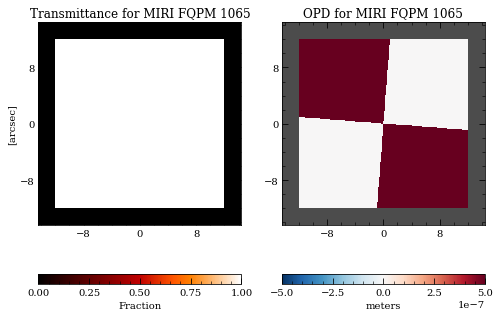

In [341]:
im.display(what='both')

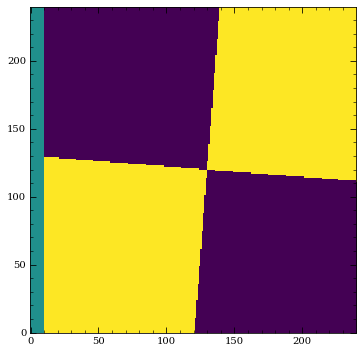

In [334]:
plt.imshow(im)
# plt.xlim([0,30])
# plt.ylim([0,30])

In [185]:
inst = webbpsf.MIRI()

[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL


In [187]:
inst.image_mask_list

False

In [188]:
inst.pixelscale

0.111

In [ ]:
inst

In [166]:
test = poppy.CircularOcculter(radius=4.25 / 2)

In [171]:
wave = poppy.Wavefront(wavelength=10e-6, npix=512, pixelscale=0.01)
im = test.get_transmission(wave)

In [174]:
im.max()

1.0

In [183]:
container = poppy.CompoundAnalyticOptic(name="MIRI Lyot Occulter",
                                        opticslist=[poppy.CircularOcculter(radius=4.25 / 2),
                                                    poppy.BarOcculter(width=0.722,height=30),
                                                    poppy.SquareFieldStop(size=30, rotation=5)])

In [178]:
wave = poppy.Wavefront(wavelength=10e-6, npix=512, pixelscale=0.1)
im = container.get_transmission(wave)

[     poppy:INFO] Computing intensity for MIRI Lyot Occulter sampled onto 512 pixel grid with pixelscale 0.0703125 arcsec / pix


<AxesSubplot:title={'center':'Transmittance for MIRI Lyot Occulter'}, ylabel='[arcsec]'>

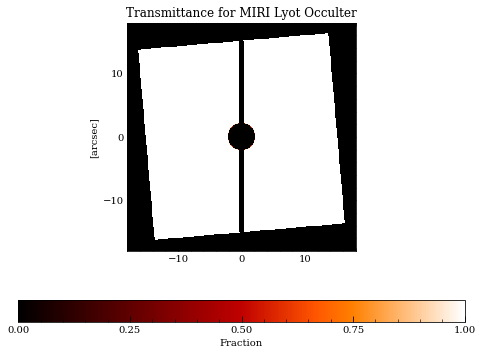

In [184]:
container.display()

In [164]:
# filter_or_bp = 'F1065C'
# mask   = 'FQPM1065'
# pupil  = 'MASKFQPM'
# apname = None
# include_si_wfe = False
# wfe_drift = None

# fov_pix = 129
# oversample = None
# opd = None
opd_default = ('OPD_RevW_ote_for_MIRI_predicted.fits.gz', 0)
# tel_pupil = None

# jitter = 'gaussian'
# jitter_sigma = 0.003

# offset_r = None
# offset_theta = None

# save_name = None
# quick = True
# use_legendre = True
# ndeg = None
# npsf = None
# return_webbpsf = False

import time
from pynrc.psfs import OPDFile_to_HDUList, OTE_Linear_Model_WSS
from pynrc.psfs import setup_logging, _log
from pynrc.psfs import nproc_use, mp, _wrap_coeff_for_mp
def gen_miri_psf_coeff(filter_or_bp, pupil=None, mask=None, 
    fov_pix=11, oversample=None, npsf=None, ndeg=None, nproc=None, 
    offset_r=None, offset_theta=None, jitter=None, jitter_sigma=0.007,
    coron_offset_x=None, coron_offset_y=None,
    tel_pupil=None, opd=None, wfe_drift=None, include_si_wfe=False,
    detector_position=None, apname=None, add_distortion=False, crop_psf=True,
    force=False, save=True, save_name=None, return_save_name=False, 
    quick=True, return_webbpsf=False, use_legendre=True, 
    return_extras=False, **kwargs):

    # Test if coronagraphic observation
    coron_obs = (pupil is not None) and (('LYOT' in pupil) or ('FQPM' in pupil))

    if oversample is None:
        oversample = 2 if coron_obs else 4

    if opd is None:  # Default OPD
        opd = opd_default
    elif isinstance(opd, six.string_types):
        opd = (opd, 0)

    # Default WFE drift
    wfe_drift = 0 if wfe_drift is None else wfe_drift
    assert wfe_drift >= 0, "wfe_drift must not be negative"

    # Get filter throughput and create bandpass
    if isinstance(filter_or_bp, six.string_types):
        filter = filter_or_bp
        bp = miri_filter(filter, pupil=pupil)
    else:
        bp = filter_or_bp
        filter = bp.name
        
    # Change log levels to WARNING for pyNRC, WebbPSF, and POPPY
    log_prev = conf.logging_level
    setup_logging('WARN', verbose=False)

    # Initialize webbpsf MIRI class
    inst = webbpsf.MIRI()
    inst.filter = filter

    if mask in list(inst.image_mask_list): 
        inst.image_mask = mask
    if pupil in list(inst.pupil_mask_list): 
        inst.pupil_mask = pupil

    inst.include_si_wfe = include_si_wfe

    # Set the SIAF aperture name
    if apname is not None:
        inst.auto_aperturename = False
        inst.aperturename = apname

    # Telescope Pupil
    if tel_pupil is not None:
        inst.pupil = tel_pupil
    
    # Get source offset positions
    if offset_r is None: 
        offset_r = 0
    if offset_theta is None: 
        offset_theta = 0
    rtemp, ttemp = (offset_r, offset_theta)
    inst.options['source_offset_r']     = rtemp
    inst.options['source_offset_theta'] = ttemp
    
    # Mask offsets
    if coron_offset_x is None: 
        coron_offset_x = 0
    if coron_offset_y is None: 
        coron_offset_y = 0
    inst.options['coron_offset_x'] = coron_offset_x
    inst.options['coron_offset_y'] = coron_offset_y

    # Telescope jitter 
    jitter_sigma = 0 if jitter is None else jitter_sigma
    inst.options['jitter'] = jitter
    inst.options['jitter_sigma'] = jitter_sigma

    # Deal with OPD file name
    #print(opd)
    if isinstance(opd, tuple):
        if not len(opd)==2:
            raise ValueError("opd passed as tuple must have length of 2.")
        # Filename info
        opd_name = opd[0] # OPD file name
        opd_num  = opd[1] # OPD slice
        rev = [s for s in opd_name.split('_') if "Rev" in s]
        rev = '' if len(rev)==0 else rev[0]
        otemp = '{}slice{:.0f}'.format(rev,opd_num)
        opd = OPDFile_to_HDUList(opd_name, opd_num)
    elif isinstance(opd, fits.HDUList):
        # A custom OPD is passed. Consider using force=True.
        otemp = 'OPDcustom'
        opd_name = 'OPD from FITS HDUlist'
        opd_num = 0
    elif isinstance(opd, poppy.OpticalElement):
        # OTE Linear Model
        # No need to do anything
        pass
    else:
        raise ValueError("OPD must be a string, tuple, or HDUList.")

    if wfe_drift>0:
        otemp = '{}-{:.0f}nm'.format(otemp,wfe_drift)

    if save_name is None:
        # Name to save array of oversampled coefficients
        save_dir = conf.PYNRC_PATH + 'psf_coeffs/'
        # Create directory if it doesn't already exist
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        # Build final filename to save coeff

        # Append filter name if using quick keyword
        fstr = '{}_'.format(filter) if quick else ''

        # Mask and pupil names
        mtemp = 'NONE' if mask is None else mask
        ptemp = 'CLEAR' if pupil is None else pupil
        
        rth_str = 'r{:.2f}_th{:+.1f}'.format(rtemp,ttemp)
        moff_str = 'mx{:.3f}_my{:.3f}'.format(coron_offset_x,coron_offset_y)

        fname = '{}{}_{}_pix{}_os{}_jsig{:.0f}_{}_{}_{}'.\
            format(fstr, ptemp, mtemp, fov_pix, oversample,\
                   jitter_sigma*1000,rth_str,mask_str,otemp)

        # Add SI WFE tag if included
        if inst.include_si_wfe:
            fname = fname + '_siwfe'

        if use_legendre:
            fname = fname + '_legendre'

        fname = fname + '.fits'
        save_name = save_dir + fname
    
    if return_save_name:
        return save_name

    # Load data from already saved FITS file
    if os.path.exists(save_name) and (not force) and (not return_webbpsf):
        #return np.load(save_name)
        # return fits.getdata(save_name)
        hdul = fits.open(save_name)
        data = hdul[0].data.astype(np.float)
        header = hdul[0].header
        hdul.close()
        return data, header

    if return_webbpsf:
        _log.info('Generating and returning WebbPSF HDUList')
    else:
        temp_str = 'and saving' if save else 'but not saving'
        _log.info('Generating {} new PSF coefficient'.format(temp_str))

    ####################################################
    # Apply WFE drift to input OPD file
    ####################################################
        
    # If there is wfe_drift, create a OTE Linear Model
    if (wfe_drift > 0):
        _log.debug('Performing WFE drift of {}nm'.format(wfe_drift))

        # OPD should already be an HDUList or OTE LM by now
        # If we want more realistic time evolution, then need to use
        # procedure in dev_utils/WebbPSF_OTE_LM.ipynb to create a time
        # series of OPDs then pass those OPDs directly to create unique PSFs
        if isinstance(opd, fits.HDUList):
            hdul = opd

            header = hdul[0].header

            header['ORIGINAL'] = (opd_name,   "Original OPD source")
            header['SLICE']    = (opd_num,    "Slice index of original OPD")
            header['WFEDRIFT'] = (wfe_drift, "WFE drift amount [nm]")

            name = 'Modified from ' + opd_name
            opd = OTE_Linear_Model_WSS(name=name, opd=hdul, opd_index=opd_num, transmission=inst.pupil)

        # Apply WFE drift to OTE Linear Model (Amplitude of frill drift)
        inst.pupilopd = opd
        inst.pupil = opd

        # Split WFE drift amplitude between three processes
        # 1) IEC Heaters; 2) Frill tensioning; 3) OTE Thermal perturbations
        # Give IEC heaters 1 nm 
        wfe_iec = 1 if np.abs(wfe_drift) > 2 else 0

        # Split remainder evenly between frill and OTE thermal slew
        wfe_remain_var = wfe_drift**2 - wfe_iec**2
        wfe_frill = np.sqrt(0.8*wfe_remain_var)
        wfe_therm = np.sqrt(0.2*wfe_remain_var)
        # wfe_th_frill = np.sqrt((wfe_drift**2 - wfe_iec**2) / 2)

        # Negate amplitude if supplying negative wfe_drift
        if wfe_drift < 0:
            wfe_frill *= -1
            wfe_therm *= -1
            wfe_iec *= -1

        # Apply IEC
        opd.apply_iec_drift(wfe_iec, delay_update=True)
        # Apply frill
        opd.apply_frill_drift(wfe_frill, delay_update=True)

        # Apply OTE thermal slew amplitude
        # This is slightly different due to how thermal slews are specified
        import astropy.units as u
        delta_time = 14*24*60 * u.min
        wfe_scale = (wfe_therm / 24)
        if wfe_scale == 0:
            delta_time = 0
        opd.thermal_slew(delta_time, case='BOL', scaling=wfe_scale)
    else:
        inst.pupilopd = opd

    
    ####################################################
    # Return WebbPSF output rather than coefficients?
    ####################################################
        
    # Change log levels to WARNING for pyNRC, WebbPSF, and POPPY
    if return_webbpsf:
        setup_logging('WARN', verbose=False)

        if 'sp_norm' in list(kwargs.keys()):
            sp_norm = kwargs['sp_norm']
        else:
            waveset = np.linspace(5, 30, 100) * 1e4
            sp_flat = S.ArraySpectrum(waveset, 0*waveset + 10.)
            sp_flat.name = 'Flat spectrum in flam'

            # Bandpass unit response is the flux (in flam) of a star that
            # produces a response of one count per second in that bandpass
            sp_norm = sp_flat.renorm(bp.unit_response(), 'flam', bp)

        t0 = time.time()
        hdu_list = inst.calc_psf(source=sp_norm, fov_pixels=fov_pix, oversample=oversample, 
                                 add_distortion=add_distortion, crop_psf=crop_psf, nlambda=npsf)
        t1 = time.time()
        setup_logging(log_prev, verbose=False)

        time_string = 'Took {:.2f} seconds to generate WebbPSF images'.format(t1-t0)
        _log.info(time_string)

        return hdu_list
    

    ####################################################
    # Wavelengths to calculate at
    ####################################################

    # Select which wavelengths to use
    # If doing a "quick" PSF, only fit the filter wavelength range.
    # Otherwise, we fit the full channel wavelength.
    if quick:
        w1 = bp.wave.min() / 1e4
        w2 = bp.wave.max() / 1e4
    else:
        w1, w2 = (5,30)
    
    # Create set of monochromatic PSFs to fit.
    if npsf is None:
        dn = 10 # 10 PSF simulations per um
        npsf = int(np.ceil(dn * (w2-w1)))

    # Want at least 5 monochromatic PSFs
    npsf = 5 if npsf<5 else int(npsf)

    ####################################################
    # Polynomial degrees and modifications to npsf
    ####################################################
    
    # First determine polynomial fit degree
    # Must ensure npsf>ndeg
    if ndeg is None:
        # TODO: Quantify these better
        if use_legendre:
            ndeg = 4 if quick else 7
        else:
            ndeg = 4 if quick else 7
    
    # Number of points must be greater than degree of fit
    npsf = ndeg+1 if npsf<=ndeg else int(npsf)
    waves = np.linspace(w1, w2, npsf)
    
    
    # How many processors to split into?
    if nproc is None:
        nproc = nproc_use(fov_pix, oversample, npsf)
    _log.debug('nprocessors: {}; npsf: {}'.format(nproc, npsf))

    setup_logging('WARN', verbose=False)
    t0 = time.time()
    # Setup the multiprocessing pool and arguments to pass to each pool
    worker_arguments = [(inst, wlen, fov_pix, oversample) for wlen in waves]
    if nproc > 1:
        pool = mp.Pool(nproc)
        # Pass arguments to the helper function

        try:
            hdu_arr = pool.map(_wrap_coeff_for_mp, worker_arguments)
            if hdu_arr[0] is None:
                raise RuntimeError('Returned None values. Issue with multiprocess or WebbPSF??')

        except Exception as e:
            _log.error('Caught an exception during multiprocess.')
            _log.error('Closing multiprocess pool.')
            pool.terminate()
            pool.close()
            raise e

        else:
            _log.debug('Closing multiprocess pool.')
            pool.close()
    else:
        # Pass arguments to the helper function
        hdu_arr = []
        for wa in worker_arguments:
            hdu = _wrap_coeff_for_mp(wa)
            if hdu is None:
                raise RuntimeError('Returned None values. Issue with WebbPSF??')
            hdu_arr.append(hdu)
    t1 = time.time()
    
    # Reset to original log levels
    setup_logging(log_prev, verbose=False)
    time_string = 'Took {:.2f} seconds to generate WebbPSF images'.format(t1-t0)
    _log.info(time_string)

    # Extract image data from HDU array
    images = []
    for hdu in hdu_arr:
        images.append(hdu.data)

    # Turn results into an numpy array (npsf,ny,nx)
    images = np.array(images)
    
    # Simultaneous polynomial fits to all pixels using linear least squares
    coeff_all = jl_poly_fit(waves, images, deg=ndeg, use_legendre=use_legendre, lxmap=[w1,w2])

    hdu = fits.PrimaryHDU(coeff_all)
    hdr = hdu.header
    head_temp = hdu_arr[0].header

    hdr['DESCR']    = ('PSF Coeffecients', 'File Description')
    hdr['NWAVES']   = (npsf, 'Number of wavelengths used in calculation')
    hdr['PUPILOPD'] = (opd_name, 'Pupil wavefront OPD source')
    hdr['OPDSLICE'] = (opd_num, 'OPD slice index')

    copy_keys = [
        'PUPILINT', 'EXTNAME', 'OVERSAMP', 'DET_SAMP',
        'PIXELSCL', 'FOV', 'JITRTYPE', 'JITRSIGM',
        'INSTRUME', 'DET_NAME', 'TEL_WFE',
        'DET_X', 'DET_Y', 'DET_V2', 'DET_V3',
        'DATE', 'AUTHOR', 'VERSION', 'DATAVERS'
    ]
    for key in copy_keys:
        try:
            hdr[key] = (head_temp[key], head_temp.comments[key])
        except (AttributeError, KeyError):
            hdr[key] = ('none', 'No key found')

    # gen_psf_coeff() Keyword Values
    hdr['FILTER'] = (filter, 'Filter Input')
    hdr['PUPIL']  = (ptemp, 'Pupil Setting')
    hdr['MASK']   = (mtemp, 'Coronagraphic Mask Setting')
    hdr['FOVPIX'] = (fov_pix, 'WebbPSF pixel FoV')
    hdr['OSAMP']  = (oversample, 'WebbPSF pixel oversample')
    hdr['NPSF']   = (npsf, 'Number of wavelengths to calc')
    hdr['NDEG']   = (ndeg, 'Polynomial fit degree')
    hdr['WAVE1']  = (w1, 'First wavelength in calc')
    hdr['WAVE2']  = (w2, 'Last of wavelength in calc')
    hdr['LEGNDR'] = (use_legendre, 'Legendre polynomial fit?')
    if tel_pupil is None:
        hdr['TELPUP'] = ('None', 'Telescope pupil')
    elif isinstance(tel_pupil, fits.HDUList):
        hdr['TELPUP'] = ('HDUList', 'Telescope pupil')
    elif isinstance(tel_pupil, six.string_types):
        hdr['TELPUP'] = (tel_pupil, 'Telescope pupil')
    else:
        hdr['TELPUP'] = ('UNKNOWN', 'Telescope pupil')
    hdr['OFFR']  = (offset_r, 'Radial offset')
    hdr['OFFTH'] = (offset_theta, 'Position angle OFFR (CCW)')
    if jitter is None:
        hdr['JITTER'] = ('None', 'Jitter type')
    else:
        hdr['JITTER'] = (jitter, 'Jitter type')
    hdr['JITSIG'] = (jitter_sigma, 'Jitter sigma')
    if opd is None:
        hdr['OPD'] = ('None', 'Telescope OPD')
    elif isinstance(opd, fits.HDUList):
        hdr['OPD'] = ('HDUList', 'Telescope OPD')
    elif isinstance(opd, six.string_types):
        hdr['OPD'] = (opd, 'Telescope OPD')
    elif isinstance(opd, poppy.OpticalElement):
        hdr['OPD'] = ('OTE Linear Model', 'Telescope OPD')
    else:
        hdr['OPD'] = ('UNKNOWN', 'Telescope OPD')
    hdr['WFEDRIFT'] = (wfe_drift, "WFE drift amount [nm]")
    hdr['SIWFE']    = (include_si_wfe, "Was SI WFE included?")
    hdr['FORCE']    = (force, "Forced calculations?")
    hdr['SAVE']     = (save, "Save file?")
    hdr['FILENAME'] = (os.path.basename(save_name), "File save name")
#     hdr['PYNRCVER'] = (__version__, "pyNRC version")

    hdr.insert('DATAVERS', '', after=True)
    hdr.insert('DATAVERS', ('','psf_coeff() Keyword Values'), after=True)
    hdr.insert('DATAVERS', '', after=True)

    hdr.add_history(time_string)

    if save:
        #np.save(save_name, coeff_all)
        hdu.writeto(save_name, overwrite=True)

    if return_extras:
        extras_dict = {'images' : images, 'waves': waves}
        return coeff_all, hdr, extras_dict
    else:
        return coeff_all, hdr


In [158]:
from pynrc.maths.coords import rtheta_to_xy

# Small grid values around center
rvals = np.linspace(-10,10,5)
thvals = np.linspace(0, 180, 6, endpoint=False)
xy_list_mas = [rtheta_to_xy(r,th) for r in rvals for th in thvals if r!=0]
xy_list_mas.append((0,0))

grid_vals = np.array(np.meshgrid(rvals,rvals))
xy_list_mas2 = [(x,y) for x,y in grid_vals.reshape([2,-1]).transpose()]

In [159]:
len(xy_list_mas)

25

In [160]:
# Corse grid along boundaries
vals = np.array([100,1000,6000,12000])
for v1 in [-50,0,50]:
    for v2 in vals:
        xy_list_mas.append((v1,v2))
        xy_list_mas.append((v1,-v2))
        xy_list_mas.append((v2,v1))
        xy_list_mas.append((-v2,v1))

for v3 in [4,8,12]:
    for v1 in [1000,-1000]:
        for v2 in [1000,-1000]:
            xy_list_mas.append((v3*v1,v3*v2))

In [161]:
xy_list_mas

[(0, -10.0),
 (4.999999999999999, -8.660254037844387),
 (8.660254037844386, -5.000000000000001),
 (10.0, -6.123233995736766e-16),
 (8.660254037844389, 4.999999999999998),
 (4.999999999999999, 8.660254037844387),
 (0, -5.0),
 (2.4999999999999996, -4.330127018922194),
 (4.330127018922193, -2.5000000000000004),
 (5.0, -3.061616997868383e-16),
 (4.3301270189221945, 2.499999999999999),
 (2.4999999999999996, 4.330127018922194),
 (0, 5.0),
 (-2.4999999999999996, 4.330127018922194),
 (-4.330127018922193, 2.5000000000000004),
 (-5.0, 3.061616997868383e-16),
 (-4.3301270189221945, -2.499999999999999),
 (-2.4999999999999996, -4.330127018922194),
 (0, 10.0),
 (-4.999999999999999, 8.660254037844387),
 (-8.660254037844386, 5.000000000000001),
 (-10.0, 6.123233995736766e-16),
 (-8.660254037844389, -4.999999999999998),
 (-4.999999999999999, -8.660254037844387),
 (0, 0),
 (-50, 100),
 (-50, -100),
 (100, -50),
 (-100, -50),
 (-50, 1000),
 (-50, -1000),
 (1000, -50),
 (-1000, -50),
 (-50, 6000),
 (-50, 

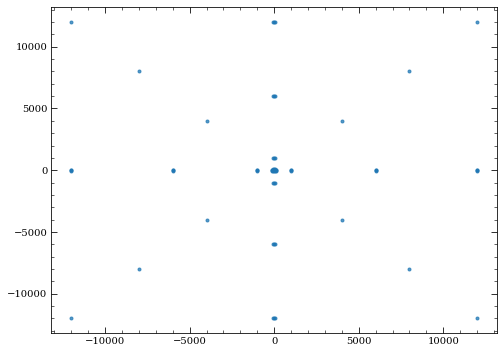

In [163]:
xvals, yvals = np.array(xy_list_mas).transpose()
plt.plot(xvals, yvals, marker='.', ls='none', alpha=0.75)

# xvals, yvals = np.array(xy_list_mas2).transpose()
# plt.plot(xvals, yvals, marker='o', ls='none', alpha=0.75)

In [81]:
cf_all, hdr, extras = gen_miri_psf_coeff('F1065C', pupil='MASKFQPM', mask='FQPM1065',
                                         fov_pix=33, save=False, return_extras=True,
                                         coron_offset_x=0.005, coron_offset_y=0)

[     pynrc:INFO] Took 12.09 seconds to generate WebbPSF images


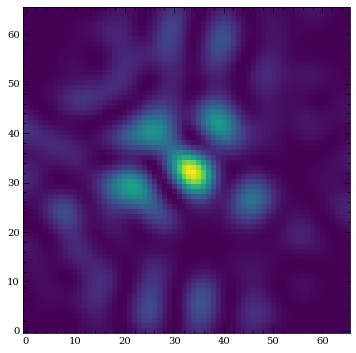

In [82]:
waves = extras['waves']
images = extras['images']

plt.imshow(images[-1])

In [83]:
cf_norm = cf_all**2 / np.sum(cf_all**2, axis=0)

for im in cf_norm:
    print(im.max(), im.mean(), np.median(im))

0.9997747914985667 0.620190098705793 0.6472025149957279
0.6546132815071753 0.2482516835494898 0.20469794531623925
0.796178869283674 0.11674888348973819 0.03842984434700557
0.5502602529421788 0.012908433355179988 0.0020940571031737767
0.3601417437108814 0.0017831401997241223 9.939857983856017e-05
0.04338249948272349 0.00011776070007488398 4.514751805430597e-06


In [66]:
indy, indx = np.argwhere(cf_norm[4]==cf_norm[4].max())[0]

In [67]:
indx, indy

(17, 35)

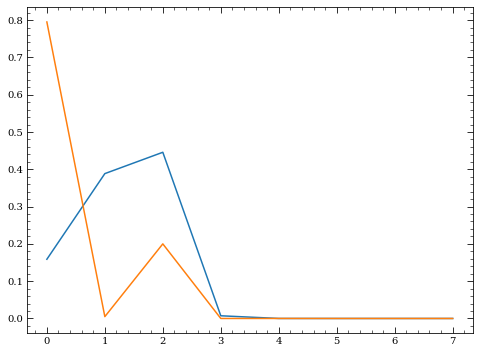

In [77]:
plt.plot(cf_norm[:,33,33])
plt.plot(cf_norm[:,45,35])

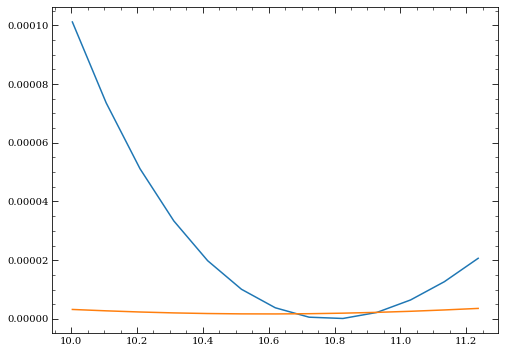

In [79]:
plt.plot(waves, images[:, 33,33])
plt.plot(waves, images[:, 45,35])

In [53]:
gen_miri_psf_coeff('F1065C', pupil='MASKFQPM', mask='FQPM1065', return_save_name=True)

'/Users/Jarron/NIRCam/pynrc_data/psf_coeffs/F1065C_MASKFQPM_FQPM1065_pix11_os2_jsig0_r0.00_th+0.0_RevWslice0_legendre.fits'

In [14]:
hdul0 = gen_miri_psf_coeff('F1065C', pupil='MASKFQPM', mask='FQPM1065',
                           fov_pix=33, save=False, return_webbpsf=True, npsf=1)

[     pynrc:INFO] Took 3.50 seconds to generate WebbPSF images


In [15]:
hdul1 = gen_miri_psf_coeff('F1065C', pupil='MASKFQPM', mask='FQPM1065',
                           fov_pix=33, save=False, return_webbpsf=True,
                           coron_offset_x=5, coron_offset_y=yoff, npsf=1)

[     pynrc:INFO] Took 3.53 seconds to generate WebbPSF images


In [122]:
# 'F1065C': 0.3, 'F1140C': 0.3, 'F1550C': 0.3, 'F2300C': 0.25,
w = '1065'
f, p, m = (f'F{w}C', 'MASKFQPM', f'FQPM{w}')

hdul2 = gen_miri_psf_coeff(f, pupil=p, mask=m,
                           fov_pix=64, save=False, return_webbpsf=True,
                           coron_offset_y=1, coron_offset_x=1, npsf=1)

[     pynrc:INFO] Took 3.07 seconds to generate WebbPSF images


In [126]:
hdul3 = gen_miri_psf_coeff(f, pupil=p, mask=m,
                           fov_pix=64, save=False, return_webbpsf=True,
                           coron_offset_y=5, coron_offset_x=5, npsf=1)

[     pynrc:INFO] Took 3.07 seconds to generate WebbPSF images


0.006694645150450457 0.5404030704112195 0.5443642084679853
-0.0005780824603699945 0.00027135770048995983


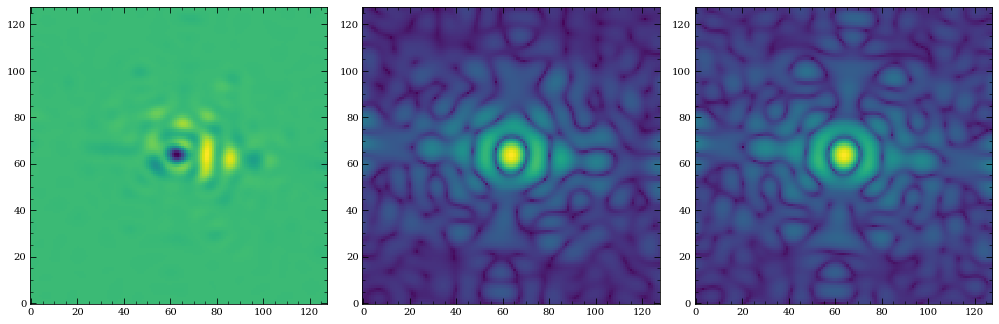

In [127]:
fig, axes = plt.subplots(1,3, figsize=(14,4.5))

print(hdul0[0].data.sum(), hdul2[0].data.sum(), hdul3[0].data.sum())

diff = hdul2[0].data-hdul3[0].data
print(diff.min(), diff.max())
axes[0].imshow(diff)
axes[1].imshow(hdul2[0].data**0.2)
axes[2].imshow(hdul3[0].data**0.2)

fig.tight_layout()

In [27]:
hdul2[0].data.max()

0.0006524422918158582

In [17]:
# Initialize webbpsf MIRI class
inst = webbpsf.MIRI()
inst.filter = 'F1065C'
inst.pupil_mask = 'MASKFQPM'
inst.image_mask = 'FQPM1065'

[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_CORON1065


In [18]:
inst._rotation

4.4497

In [35]:
%%time 
webbpsf.webbpsf_core.poppy.conf.use_multiprocessing

hdul = inst.calc_psf(fov_pixels=108, oversample=4, add_distortion=False, crop_psf=True, monochromatic=10*1e-6)

[     poppy:INFO] Monochromatic calculation requested.
[     poppy:INFO] PSF calc using fov_pixels = 108, oversample = 4, number of wavelengths = 1
[   webbpsf:INFO] Creating optical system model:
[     poppy:INFO] Initialized OpticalSystem: JWST+MIRI
[     poppy:INFO] JWST Entrance Pupil: Loaded amplitude transmission from /Users/Jarron/NIRCam/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[     poppy:INFO] JWST Entrance Pupil: Loaded OPD from /Users/Jarron/NIRCam/webbpsf-data/MIRI/OPD/OPD_RevW_ote_for_MIRI_requirements.fits.gz
[     poppy:INFO] Added pupil plane: JWST Entrance Pupil
[     poppy:INFO] Added coordinate inversion plane: OTE exit pupil
[     poppy:INFO] Added rotation plane: Rotation by 4.45 degrees
[     poppy:INFO] Added pupil plane: MIRI internal WFE at V2V3=(-6.56,-7.02)', near ISIM11
[     poppy:INFO] Added pupil plane: FQPM FFT aligner
[     poppy:INFO] Added image plane: MIRI FQPM 1065
[     poppy:INFO] Added pupil plane: FQPM FFT aligner
[   webbpsf:INFO] Setting 

In [45]:
webbpsf.webbpsf_core.poppy.conf.use_multiprocessing = False

In [47]:
%time hdul = inst.calc_psf(fov_pixels=108, oversample=2, add_distortion=False, crop_psf=True)

[     poppy:INFO] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[     poppy:INFO] PSF calc using fov_pixels = 108, oversample = 2, number of wavelengths = 9
[   webbpsf:INFO] Creating optical system model:
[     poppy:INFO] Initialized OpticalSystem: JWST+MIRI
[     poppy:INFO] JWST Entrance Pupil: Loaded amplitude transmission from /Users/Jarron/NIRCam/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[     poppy:INFO] JWST Entrance Pupil: Loaded OPD from /Users/Jarron/NIRCam/webbpsf-data/MIRI/OPD/OPD_RevW_ote_for_MIRI_requirements.fits.gz
[     poppy:INFO] Added pupil plane: JWST Entrance Pupil
[     poppy:INFO] Added coordinate inversion plane: OTE exit pupil
[     poppy:INFO] Added rotation plane: Rotation by 4.45 degrees
[     poppy:INFO] Added pupil plane: MIRI internal WFE at V2V3=(-6.56,-7.02)', near ISIM11
[     poppy:INFO] Added pupil plane: FQPM FFT aligner
[     poppy:INFO] Added image plane: MIRI FQPM 1065
[     poppy:INFO] Added pupil plane: FQPM FFT a

In [15]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  432                                                  
NAXIS2  =                  432                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 9.88434138854330E-06 / Weighted mean wavelength in meters             
DIFFLMT =   0.2830410644136973 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.02775 / Scale in arcsec/pix (after oversampling)       
FOV     =               11.9